** *
# Dog Breed Identification

---


https://www.kaggle.com/c/dog-breed-identification


>[Dog Breed Identification](#scrollTo=zMYQUkNl3e3I)

>[Initial Setup](#scrollTo=U0PO6PE-0JFr)

>>[Download Dataset](#scrollTo=afqc3ABYzOTC)

>>[Install PyTorch](#scrollTo=AXQ7uiJTzevw)

>[Data Analysis](#scrollTo=YdVbWgtN0BE2)

>>[Data Transformation](#scrollTo=OX9veUXEz0Xp)

>>[DogBreedDataset class](#scrollTo=SK_sXXDL0xl8)

>>[DataLoader](#scrollTo=38mfU_Dd051q)

>[Data visualization](#scrollTo=klhuuas21AhV)

>>[Class distribution](#scrollTo=JnSwCJ2M0dei)

>[ConvNet models](#scrollTo=5gq2xhMa1fiN)

>[Training model](#scrollTo=N8-2cZZE8sY7)

>>[Features Extraction](#scrollTo=yfatwrEl1uBb)

>>[Fine Tuning](#scrollTo=QsLkYLgL1-CX)

>[Model Evaluation](#scrollTo=oUKw_1pz2Mmw)

>>[Mismatch predictions](#scrollTo=S88aQ1uh5A3x)

>>[Confusion Matrix](#scrollTo=WKgowbMf2Yj9)

>>[Layers Weights](#scrollTo=UsiKMA915HPH)

>[Generate Submission File](#scrollTo=tLcumaz3RkeO)



# Initial Setup

## Download Dataset

In [11]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

if not os.path.exists('data/'):

    auth.authenticate_user()

    drive_service = build('drive', 'v3')
    results = drive_service.files().list(
            q="name = 'kaggle.json'", fields="files(id)").execute()
    kaggle_api_key = results.get('files', [])

    filename = "/content/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(filename, 600)

    !kaggle competitions download -c dog-breed-identification -p data/ && cd data && ls && unzip train.zip && unzip test.zip && unzip labels.csv.zip
    
    
else:
    print('Dataset already downloaded!')

Dataset already downloaded!


## Install PyTorch

In [12]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
!pip install kaggle

# Data Analysis

In [0]:
import numpy as np
import torchvision.transforms as transforms
import torch

In [14]:
gpu_count = torch.cuda.device_count()
print("{} GPU's available:".format(gpu_count) )
cpu_count = torch.multiprocessing.cpu_count()
print("\ncpu_count: {}".format(cpu_count))

1 GPU's available:

cpu_count: 2


In [15]:
if gpu_count != 0:
    !free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        456M        7.0G        247M        5.3G         11G
Swap:            0B          0B          0B


In [0]:
datadir = 'data/'

In [0]:
import pandas as pd


labels = pd.read_csv(os.path.join(datadir, 'labels.csv'))

selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(len(labels)).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

In [0]:
NUM_CLASSES = labels_pivot.shape[-1] - 1


In [19]:
labels_pivot.head()

breed                                id  affenpinscher  afghan_hound  \
0      000bec180eb18c7604dcecc8fe0dba07            0.0           0.0   
1      001513dfcb2ffafc82cccf4d8bbaba97            0.0           0.0   
2      001cdf01b096e06d78e9e5112d419397            0.0           0.0   
3      00214f311d5d2247d5dfe4fe24b2303d            0.0           0.0   
4      0021f9ceb3235effd7fcde7f7538ed62            0.0           0.0   

breed  african_hunting_dog  airedale  american_staffordshire_terrier  \
0                      0.0       0.0                             0.0   
1                      0.0       0.0                             0.0   
2                      0.0       0.0                             0.0   
3                      0.0       0.0                             0.0   
4                      0.0       0.0                             0.0   

breed  appenzeller  australian_terrier  basenji  basset        ...          \
0              0.0                 0.0      0.0     0.0        ...           
1              0.0                 0.0      0.0     0.0        ...           
2              0.0                 0.0      0.0     0.0        ...           
3              0.0                 0.0      0.0     0.0        ...           
4              0.0                 0.0      0.0     0.0        ...           

breed  toy_poodle  toy_terrier  vizsla  walker_hound  weimaraner  \
0             0.0          0.0     0.0           0.0         0.0   
1             0.0          0.0     0.0           0.0         0.0   
2             0.0          0.0     0.0           0.0         0.0   
3             0.0          0.0     0.0           0.0         0.0   
4             0.0          0.0     0.0           0.0         0.0   

breed  welsh_springer_spaniel  west_highland_white_terrier  whippet  \
0                         0.0                          0.0      0.0   
1                         0.0                          0.0      0.0   
2                         0.0                          0.0      0.0   
3                         0.0                          0.0      0.0   
4                         0.0                          0.0      0.0   

breed  wire-haired_fox_terrier  yorkshire_terrier  
0                          0.0                0.0  
1                          0.0                0.0  
2                          0.0                0.0  
3                          0.0                0.0  
4                          0.0                0.0  

[5 rows x 121 columns]

## Data Transformation

In [0]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

img_width = img_height=300 #to use InceptionV3 it must img_width and img_height be changed to 300

# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ])
}

## DogBreedDataset class

In [0]:
from torch.utils.data import Dataset
import random
from PIL import Image
import glob

class DogBreedDataset(Dataset):
    
    def __init__(self, path, labels=pd.DataFrame(), transforms=None):
    
        self.X = glob.glob(path)
        self.labels = labels
        self.transform = transforms     
        
    def __getitem__(self, idx):
      
        
        fullname = self.X[idx]
        img_id = os.path.splitext(fullname)[0].split('/')[-1]
        img = Image.open(fullname)

        if not self.labels.empty:
            labels = self.labels[self.labels['id'] == img_id].iloc[0, 1:].as_matrix().astype('float')
            labels = np.argmax(labels)
        else:
            labels = -1

        if self.transform is not None:
            img = self.transform(img)
          
        return img, labels

    def __len__(self):
        return len(self.X)
        
 

In [0]:
dsets = {
    'train': DogBreedDataset(path=os.path.join(datadir, 'train/*.jpg'), labels=labels_pivot, transforms=data_transforms['train']),
    'valid': DogBreedDataset(path=os.path.join(datadir, 'train/*.jpg'), labels=labels_pivot, transforms=data_transforms['train']),
    'test': DogBreedDataset(path=os.path.join(datadir, 'test/*.jpg'),  transforms=data_transforms['train'])
}
  

In [0]:
batch_size = 32

random_seed = 3
shuffle = True
valid_size = 0.2

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler


num_train = len(dsets['train'])
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

sampler = {'train': train_sampler,
          'valid': valid_sampler,
          'test': None}

## DataLoader


In [0]:
from torch.utils.data import DataLoader

def create_dataLoader(dsets, batch_size, sampler={'train': None, 'valid': None,'test': None},
                      pin_memory=False):
  
    dset_loaders = {} 
    shuffle = False
    for key in dsets.keys():
        if sampler[key] != None:
          dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, sampler=sampler[key], pin_memory=pin_memory)
        else: 
          use_shuffle = False
         
          dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, pin_memory=pin_memory, shuffle=use_shuffle)

    return dset_loaders

In [0]:
dset_loaders = create_dataLoader(dsets, batch_size, sampler, pin_memory=False)

In [27]:
for k in dset_loaders.keys():
  print('{} Loader: {}'.format(k, len(dset_loaders[k])))

train Loader: 256
valid Loader: 64
test Loader: 324


# Data visualization

In [0]:
import numpy as np

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))  # Channel Last
    img = std * inp + mean
    return img

In [0]:
#!pip install --no-cache-dir -I pillow

In [0]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

def plot_classes(dset_loaders, labels, path2save = './figures/data.png'):
    inputs, cls = next(iter(dset_loaders))
    fig = plt.figure(figsize=(15,6))
    for i, j in enumerate(range(0,10)):
        fig.add_subplot(2,5, i+1)
        img = denormalize(inputs.numpy()[j])
        img = np.clip(img, 0, 1.0)
        plt.imshow(img)
        plt.title('{}'.format(labels[cls[j]]))
        plt.axis('off')

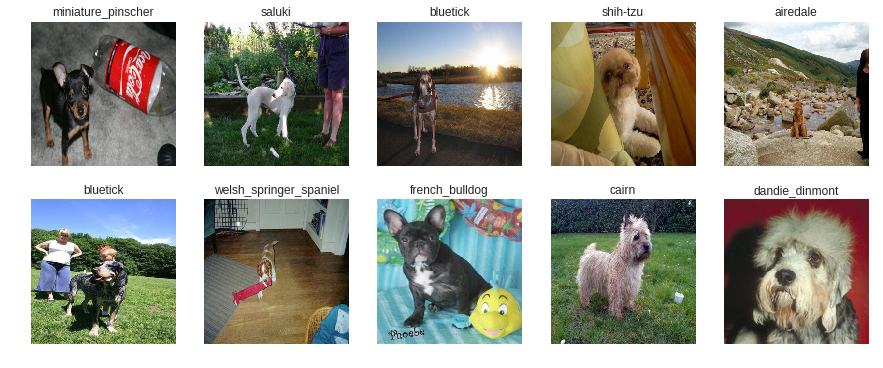

In [31]:
plot_classes(dset_loaders['train'], labels_pivot.columns[1:])

## Class distribution

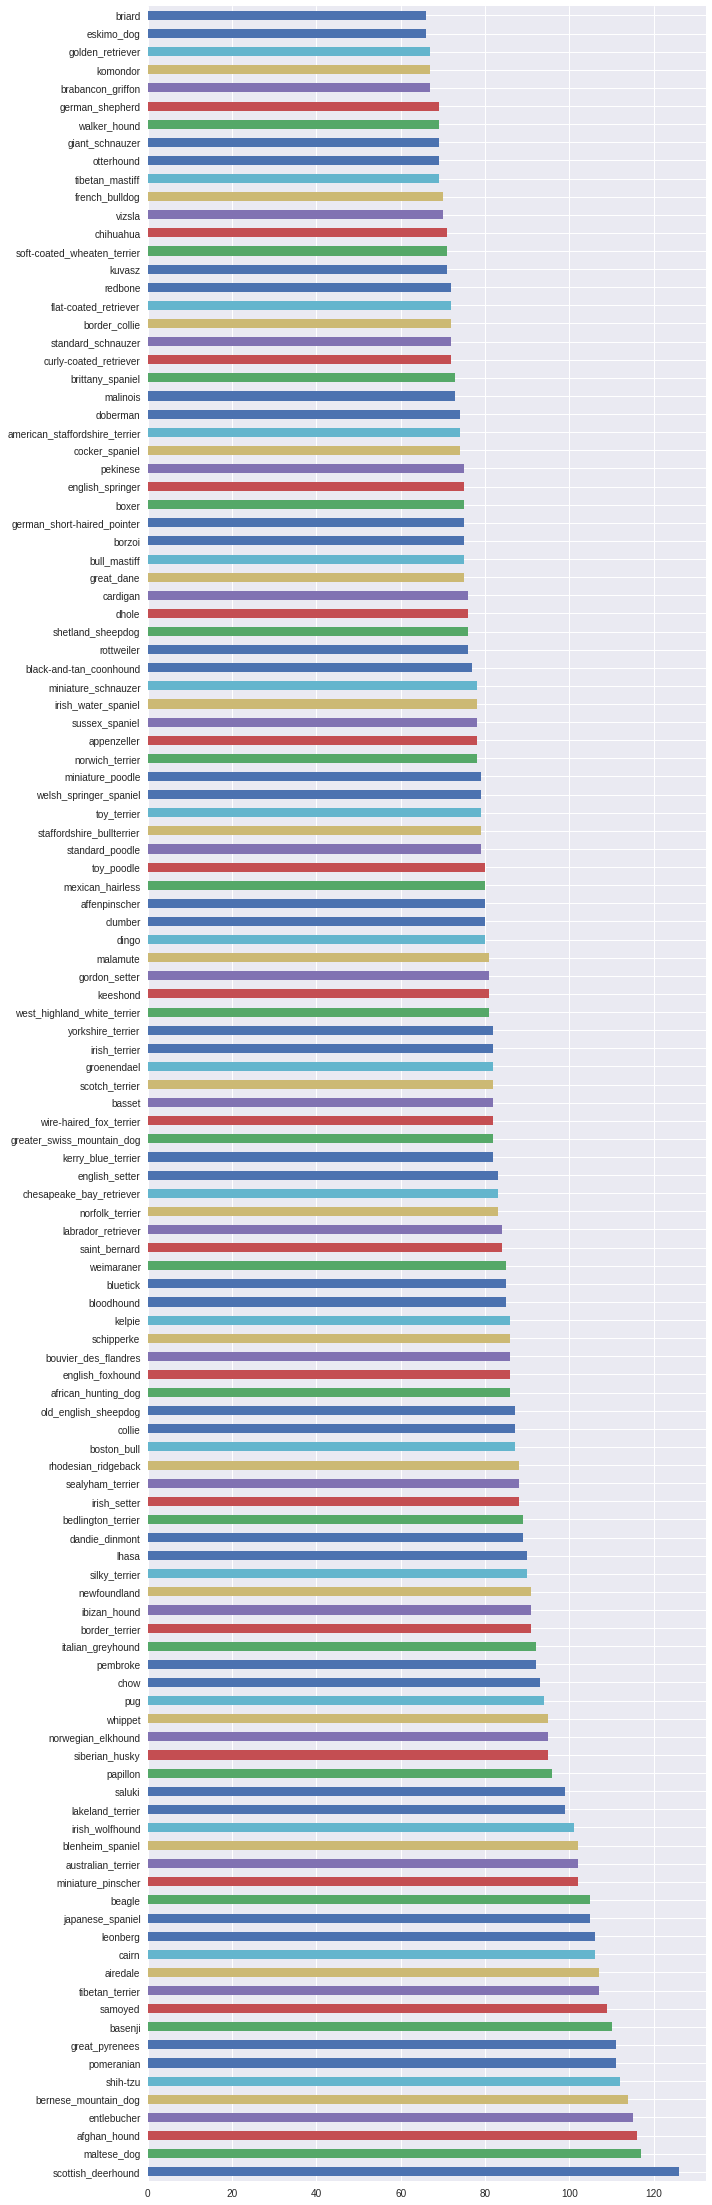

In [32]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 40))
labels.breed.value_counts().plot(kind = 'barh')

# ConvNet models

In [33]:
import torchvision
nb_out = NUM_CLASSES
print('Number of classes: {}'.format(nb_out))

Number of classes: 120


In [0]:
class MyResNetConv(torchvision.models.ResNet):
    def __init__(self, fixed_extractor = True):
        super().__init__(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2])
        self.load_state_dict(torch.utils.model_zoo.load_url(
            'https://download.pytorch.org/models/resnet18-5c106cde.pth'))
        
        del self.fc
        
        if fixed_extractor:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

class MyResNetDens(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dens1 = torch.nn.Linear(in_features=6400, out_features=512)
        self.dens2 = torch.nn.Linear(in_features=512, out_features=128)
        self.dens3 = torch.nn.Linear(in_features=128, out_features=nb_out)
        
    def forward(self, x):
        x = self.dens1(x)
        x = torch.nn.functional.selu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.dens2(x)
        x = torch.nn.functional.selu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.dens3(x)
        return x

class MyResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mrnc = MyResNetConv()
        self.mrnd = MyResNetDens()
        
    def forward(self, x):
        x = self.mrnc(x)
        x = self.mrnd(x)
        return x

In [0]:
# http://pytorch.org/docs/0.2.0/_modules/torchvision/models/densenet.html
# https://discuss.pytorch.org/t/densenet-transfer-learning/7776

class MyDenseNetConv(torch.nn.Module):
    def __init__(self, fixed_extractor = True):
        super(MyDenseNetConv,self).__init__()
        original_model = torchvision.models.densenet161(pretrained=True)
        self.features = torch.nn.Sequential(*list(original_model.children())[:-1])
        
        if fixed_extractor:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = F.relu(x, inplace=True)
        x = F.avg_pool2d(x, kernel_size=7).view(x.size(0), -1)
        return x
        
class MyDenseNetDens(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dens1 = torch.nn.Linear(in_features=2208, out_features=512)
        self.dens2 = torch.nn.Linear(in_features=512, out_features=128)
        self.dens3 = torch.nn.Linear(in_features=128, out_features=nb_out)
        
    def forward(self, x):
        x = self.dens1(x)
        x = torch.nn.functional.selu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.dens2(x)
        x = torch.nn.functional.selu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.dens3(x)
        return x


class MyDenseNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mrnc = MyDenseNetConv()
        self.mrnd = MyDenseNetDens()
    def forward(self, x):
        x = self.mrnc(x)
        x = self.mrnd(x)
        return x 

In [0]:
model_name = "DenseNet"   

if model_name == "DenseNet":
  model = MyDenseNet()

elif model_name == "ResNet" :
  model = MyResNet()

In [100]:
print(model)

MyDenseNet(
  (mrnc): MyDenseNetConv(
    (features): Sequential(
      (0): Sequential(
        (conv0): Conv2d (3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu0): ReLU(inplace)
        (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
            (relu1): ReLU(inplace)
            (conv1): Conv2d (96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
            (relu2): ReLU(inplace)
            (conv2): Conv2d (192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _DenseLayer(
            (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True)
            

In [101]:
use_DataParalel = True

if gpu_count != 0:
    use_gpu = True
    if use_DataParalel:
        print("Using all GPU's ")
       
        model.mrnc = torch.nn.DataParallel(model.mrnc) #device_ids=[1,3]
        convnet = model.mrnc.cuda()
        model.mrnd = torch.nn.DataParallel(model.mrnd) #device_ids=[1,3]
        model.mrnd = model.mrnd.cuda()
        
    else:
        print('Using GPU')# {}'.format(device_id))
        model.cuda()
        convnet = model.mrnc 

else:
    print("Using CPU's")
    use_gpu = False
    convnet = model.mrnc

Using all GPU's 


# Training model

## Features Extraction

In [0]:
import time
from torch.autograd import Variable
import torch.nn.functional as F


def predict(dset_loaders, model,use_gpu=False):
    
    predictions = []
    labels_lst = []

    ii_n = len(dset_loaders)
    start_time = time.time()

    for i, (inputs, labels) in enumerate(dset_loaders):
                   
        if use_gpu:
          inputs = inputs.cuda()
          labels = labels.cuda()

        inputs = Variable(inputs)
        labels = Variable(labels)

        predictions.append(model(inputs).data)
        labels_lst.append(labels)
        
        print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')
    print(' ok')
    print('Execution time {0:.2f} s'.format(round(time.time()- start_time), 2))
    if len(predictions) > 0:
        return {'pred': torch.cat(predictions, 0), 'true': torch.cat(labels_lst, 0) }

In [41]:
from torch.utils.data import  TensorDataset

#extract features from images

convOutput_train = {}
conv_dset = {}

for k in dset_loaders.keys():
  convOutput_train[k] = predict(dset_loaders[k], convnet, use_gpu=use_gpu)
  
  train_data = convOutput_train[k]['pred']
  our_labels = convOutput_train[k]['true'].cpu().data

  if use_gpu:
      conv_dset[k] = TensorDataset(train_data.cuda(), our_labels.cuda())
  else:
      conv_dset[k] = TensorDataset(train_data, our_labels)

predict: 255/255 ok
Execution time 299.00 s
predict: 63/63 ok
Execution time 74.00 s
predict: 323/323 ok
Execution time 379.00 s


In [0]:
dset_loaders_convnet = create_dataLoader(conv_dset, batch_size, pin_memory=False)

## Fine Tuning

In [0]:
def evaluate_model(loader, model, loss_fn, use_gpu = False):
    
    total_loss = 0
    for i, ( inputs, labels) in enumerate(loader):     
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
                
        # forward pass
        outputs = model(inputs)
        # loss
        loss = loss_fn(outputs, labels)
        
        # metrics
        total_loss += loss.data[0]
            
    return (total_loss / i)

In [0]:
import copy


def train(model, train_loader, test_loader ,num_epochs, loss_fn, optimizer, patience  ):
    
    loss_train = []
    loss_test = []
    best_test_acc =  np.inf
    
    patience_count= 0
    ii_n = len(train_loader)
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            
            print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')

            if use_gpu:
              
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
                
            
            predict = model(inputs)
            
            loss = loss_fn(predict, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        loss_train.append(loss.data[0])
        loss_test.append( evaluate_model(test_loader, model,loss_fn, use_gpu) )
        
        print(' Epoch: {}  Loss Train: {}  Lost Test: {}'.format(epoch, loss_train[-1], loss_test[-1]), end='\n')
        #Early stopping
        
        
        if(best_test_acc > loss_test[-1]):
            patience_count = 0
            best_test_acc = loss_test[-1]
            best_model = copy.deepcopy(model)

        if(patience_count > patience):
            break;

        patience_count += 1
        
        
    print('\rDone!')
    return loss_train, loss_test, model

In [0]:
import torch.nn as nn
import torch.optim as optim


num_epochs  = 50

loss_fn = nn.CrossEntropyLoss()
optimizer =  optim.Adam(model.mrnd.parameters(), lr=1e-3,weight_decay=0)
patience = 10

In [0]:
params  =  {'model'  :  model.mrnd, 
             'train_loader':dset_loaders_convnet['train'],
             'test_loader':dset_loaders_convnet['valid'],
             'num_epochs': num_epochs,
             'loss_fn': loss_fn,
             'optimizer': optimizer, 
             'patience': patience 
            }

In [104]:
loss_train, loss_test, model.mrnd   = train(**params)

predict: 255/255 Epoch: 0  Loss Train: 0.7581894397735596  Lost Test: 0.9866120578750731
predict: 255/255 Epoch: 1  Loss Train: 0.6911970376968384  Lost Test: 0.8690394910555037
predict: 255/255 Epoch: 2  Loss Train: 0.4287984073162079  Lost Test: 0.7790395768861922
predict: 255/255 Epoch: 3  Loss Train: 0.14341047406196594  Lost Test: 0.7815105626507411
predict: 255/255 Epoch: 4  Loss Train: 0.4702474772930145  Lost Test: 0.876091209195909
predict: 255/255 Epoch: 5  Loss Train: 0.19337384402751923  Lost Test: 0.838208459199421
predict: 255/255 Epoch: 6  Loss Train: 0.5071558952331543  Lost Test: 0.9466594727266402
predict: 255/255 Epoch: 7  Loss Train: 0.0825783908367157  Lost Test: 1.016339781738463
predict: 255/255 Epoch: 8  Loss Train: 0.08865123242139816  Lost Test: 0.8981112272493423
predict: 255/255 Epoch: 9  Loss Train: 0.4675862491130829  Lost Test: 1.1248208677011824
predict: 255/255 Epoch: 10  Loss Train: 0.04711977764964104  Lost Test: 0.9854511396279411
predict: 255/255 Ep

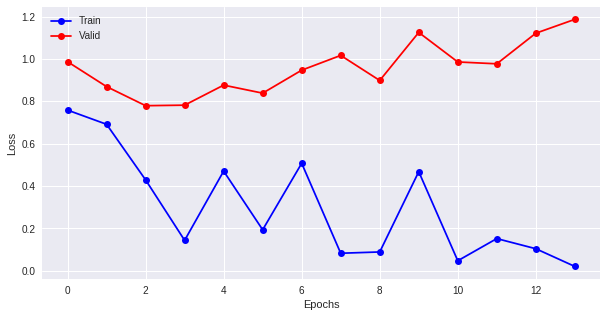

In [105]:
plt.figure(figsize=(10,5))
plt.plot(loss_train, '-bo', label='Train')
plt.plot(loss_test, '-ro', label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [0]:
dset_loaders_without_shuffle = create_dataLoader(dsets, batch_size, pin_memory=False)

In [50]:
results_w_shuffle = {}
results = {}
k = 'train'
results_w_shuffle[k] = predict(dset_loaders_without_shuffle[k], model, use_gpu=use_gpu)

for k in dset_loaders.keys():
    results[k] = predict(dset_loaders[k], model, use_gpu=use_gpu)

predict: 319/319 ok
Execution time 376.00 s
predict: 255/255 ok
Execution time 302.00 s
predict: 63/63 ok
Execution time 75.00 s
predict: 323/323 ok
Execution time 383.00 s


# Model Evaluation

In [122]:
for k in results.keys(): 
  
    _, predicted = torch.max(results[k]['pred'], 1)  
    if use_gpu:
        true, pred = results[k]['true'].cpu(), predicted.cpu()
    
    true, pred = true.data.numpy(), pred.numpy()
    correct = (true == pred).sum()
    print('{}: {}/{}'.format(k, correct, len(results['train']['pred'])))

train: 7034/8178
valid: 1546/8178
test: 0/8178


## Mismatch predictions

In [0]:
def visualize_predictions(results, dset, mode='wrong', order = 'desc', path2save = []):
    
    _, predicted = torch.max(results['pred'], 1)  
    probas_matrix = torch.nn.functional.softmax(Variable(results['pred']))
    probas, _ = torch.max(probas_matrix, 1)
    
    if use_gpu:
      probas = probas.cpu()
      label_true = results['true'].cpu()
      predicted = predicted.cpu()
      
    probas = probas.data.numpy()
    label_true = label_true.data.numpy()
    predicted = predicted.numpy()
    

    i_not_egal = np.where(label_true != predicted)[0]
    i_egal = np.where(label_true == predicted)[0]
    

    if ((mode == 'right') and (order =='asc')):
      
        lst = i_egal
        top_predictions = np.argsort(probas[lst])
    elif ((mode == 'right') and (order == 'desc')):
      
        lst = i_egal
        top_predictions = np.argsort(probas[lst])[::-1]
    if ((mode == 'wrong') and (order == 'asc')):
      
        lst = i_not_egal
        top_predictions = np.argsort(probas[lst])
    elif ((mode == 'wrong') and (order == 'desc')):
        
        lst = i_not_egal
        top_predictions = np.argsort(probas[lst])[::-1]


    
    
    maxSubPlot = 4
    fig = plt.figure(figsize=(15,6))
    for i, j in enumerate(range(0,maxSubPlot)):
        fig.add_subplot(1, maxSubPlot, i+1)
        (inputs, output) = dset[lst[top_predictions[j]]]
        img = denormalize(inputs.cpu().numpy())
        img = np.clip(img, 0, 1.0)
        plt.imshow(img)
        
        plt.title('{}/{}:{:0.3f}'.format(output, 
                                         predicted[lst[top_predictions[j]]], \
                                         probas[lst[top_predictions[j]]]))
        plt.axis('off')
    if len(path2save) !=0:
        fig.savefig(path2save) 
        
        
    return lst

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


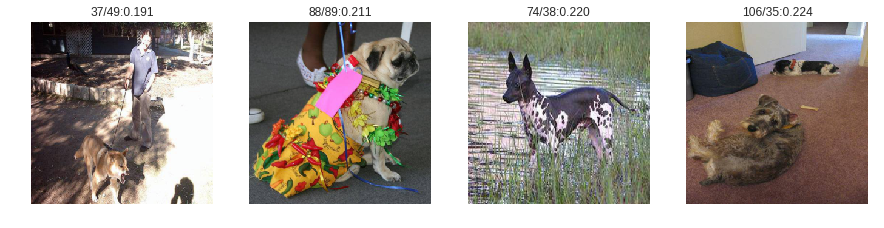

In [52]:
lst = visualize_predictions(results_w_shuffle['train'], dsets['train'], mode='wrong', order='asc')

## Confusion Matrix

In [0]:
def plot_cm(results):

    true = results['true']
    _, predicted = torch.max(results['pred'], 1)  

    if use_gpu:
      predicted = predicted.cpu()
      true = true.cpu()


    predicted = predicted.numpy()
    true = true.data.numpy()

    mc = np.array(pd.crosstab(predicted, true))
    plt.imshow(mc/mc.sum(axis=0), cmap = 'jet')
    plt.colorbar()
    plt.axis('off')

Text(0.5,1,'Confusion matrix Validation set')

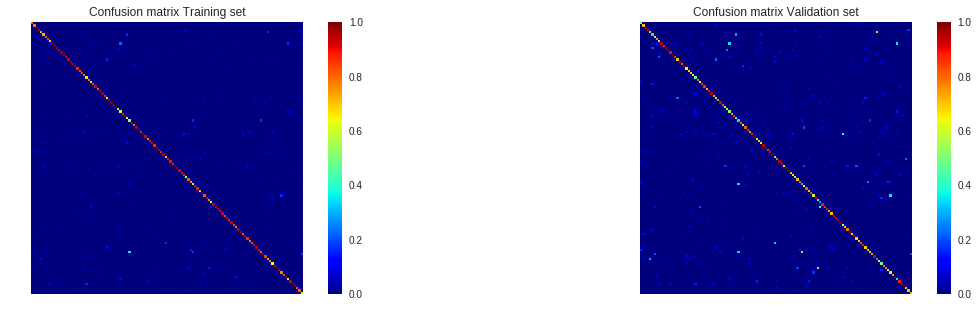

In [54]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,2,1)

plot_cm(results['train'])
plt.title('Confusion matrix Training set')

plt.subplot(1,2,2)
plot_cm(results['valid'])
plt.title('Confusion matrix Validation set')


## Layers Weights

In [0]:
def plot_layers_weight(dsets,img_width, img_height, conv_model,use_gpu, ncols = 8, H = 14, W=30):


    rand_idx = random.randrange(0, len(dsets))
    input, _ = dsets[rand_idx]
    input = input.view(1, 3, img_width, img_height)
    

    if use_gpu:
        x = Variable(input.cuda())
    else:
        x = Variable(input)

    for name, layer in conv_model.named_children():
        x = layer(x)
        grid = torchvision.utils.make_grid(torch.transpose(x.data, 0, 1), normalize=True, 
                                           pad_value=1.0, padding=1).cpu().numpy()

        if name == 'max_pool':
            H /= 3/2
            W /= 3/2
        fig = plt.figure(figsize=(H,W))
        plt.imshow(grid.transpose((1,2,0)))

        plt.title(name)
        plt.axis('off')


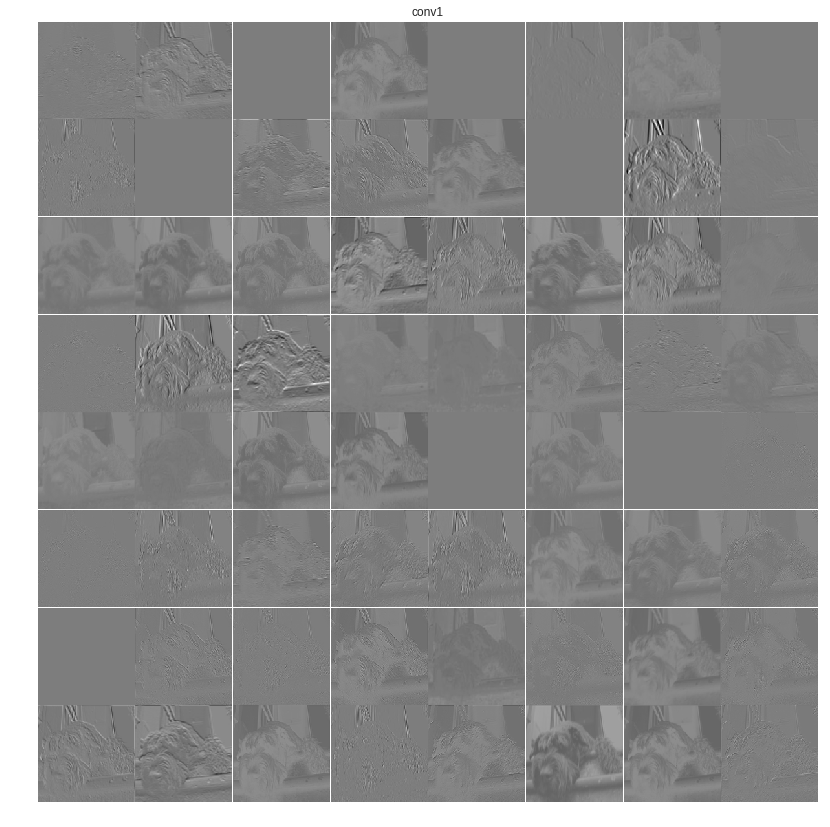

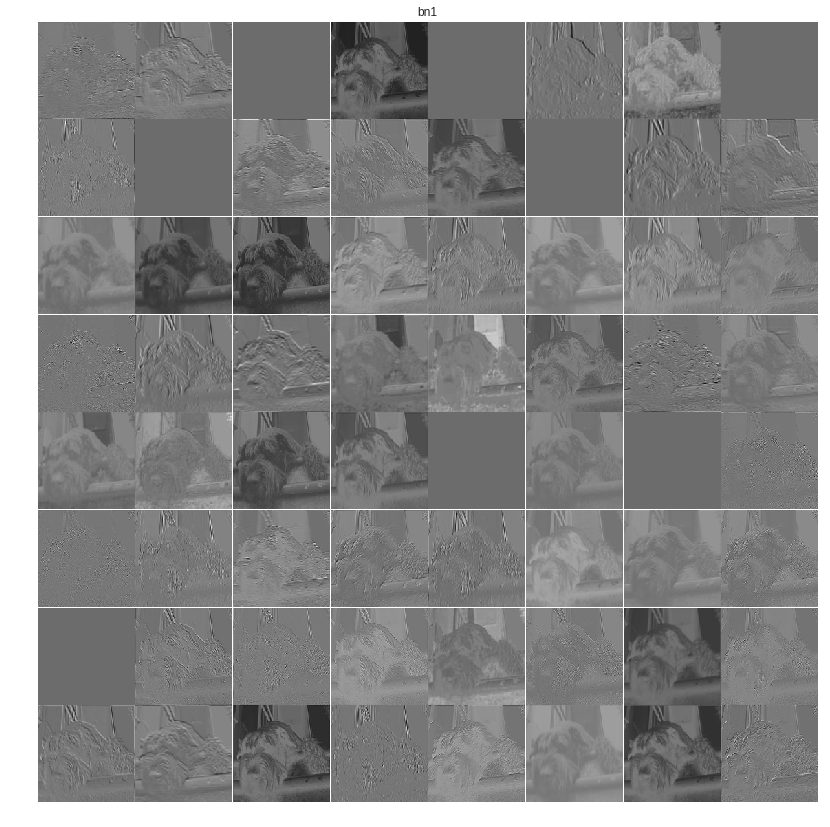

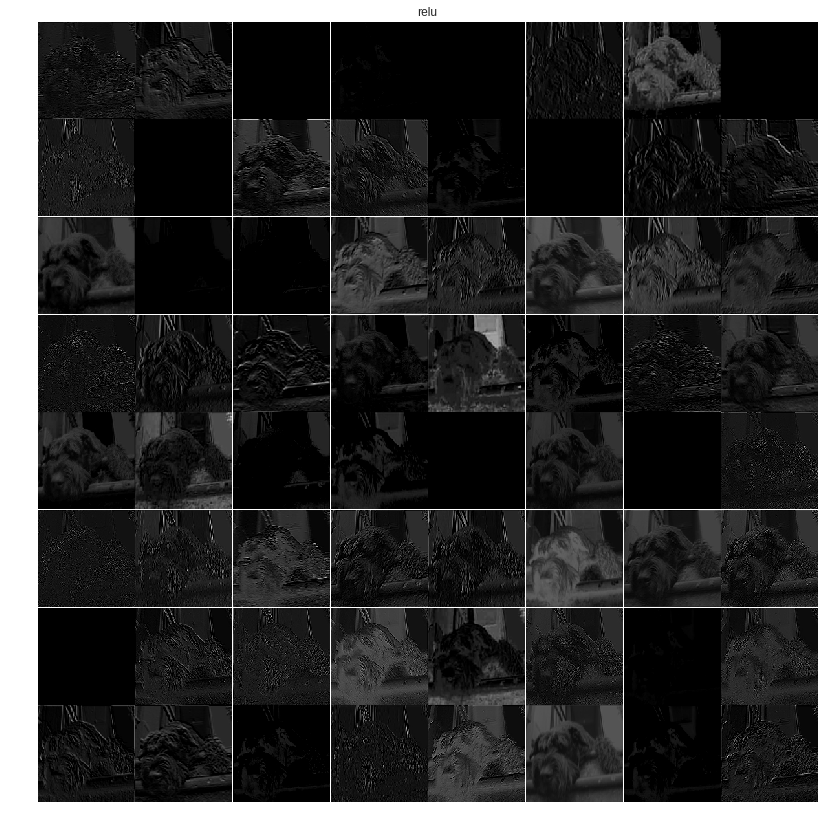

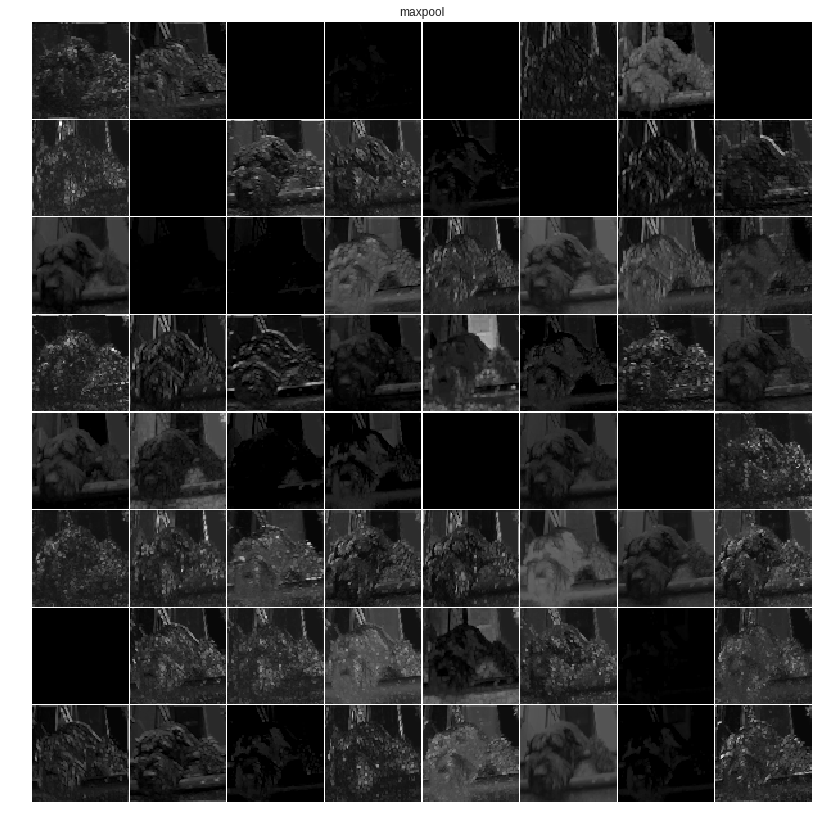

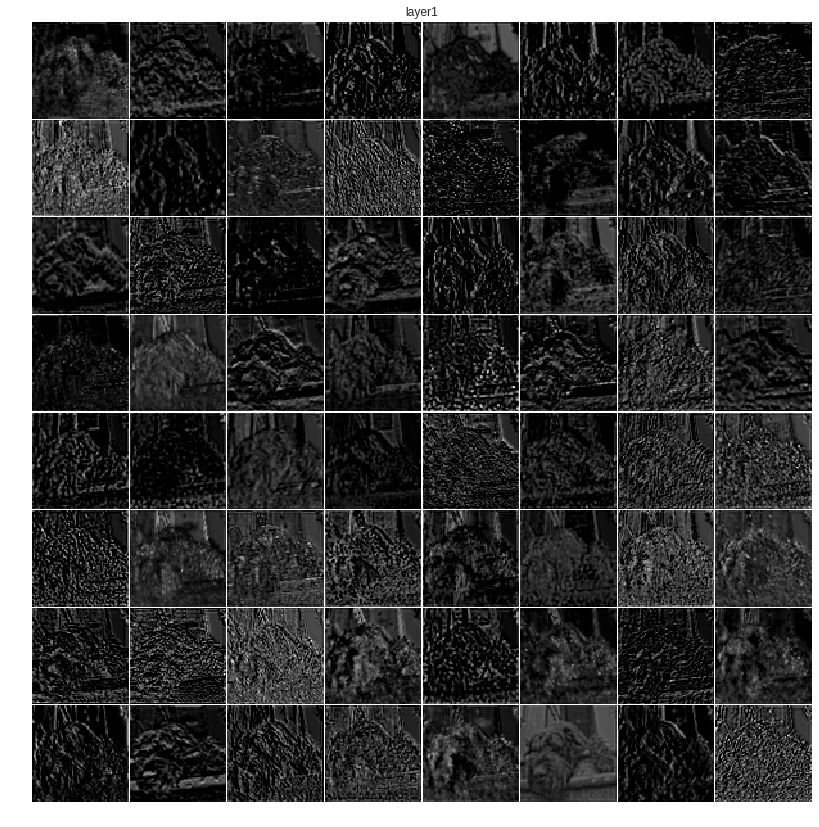

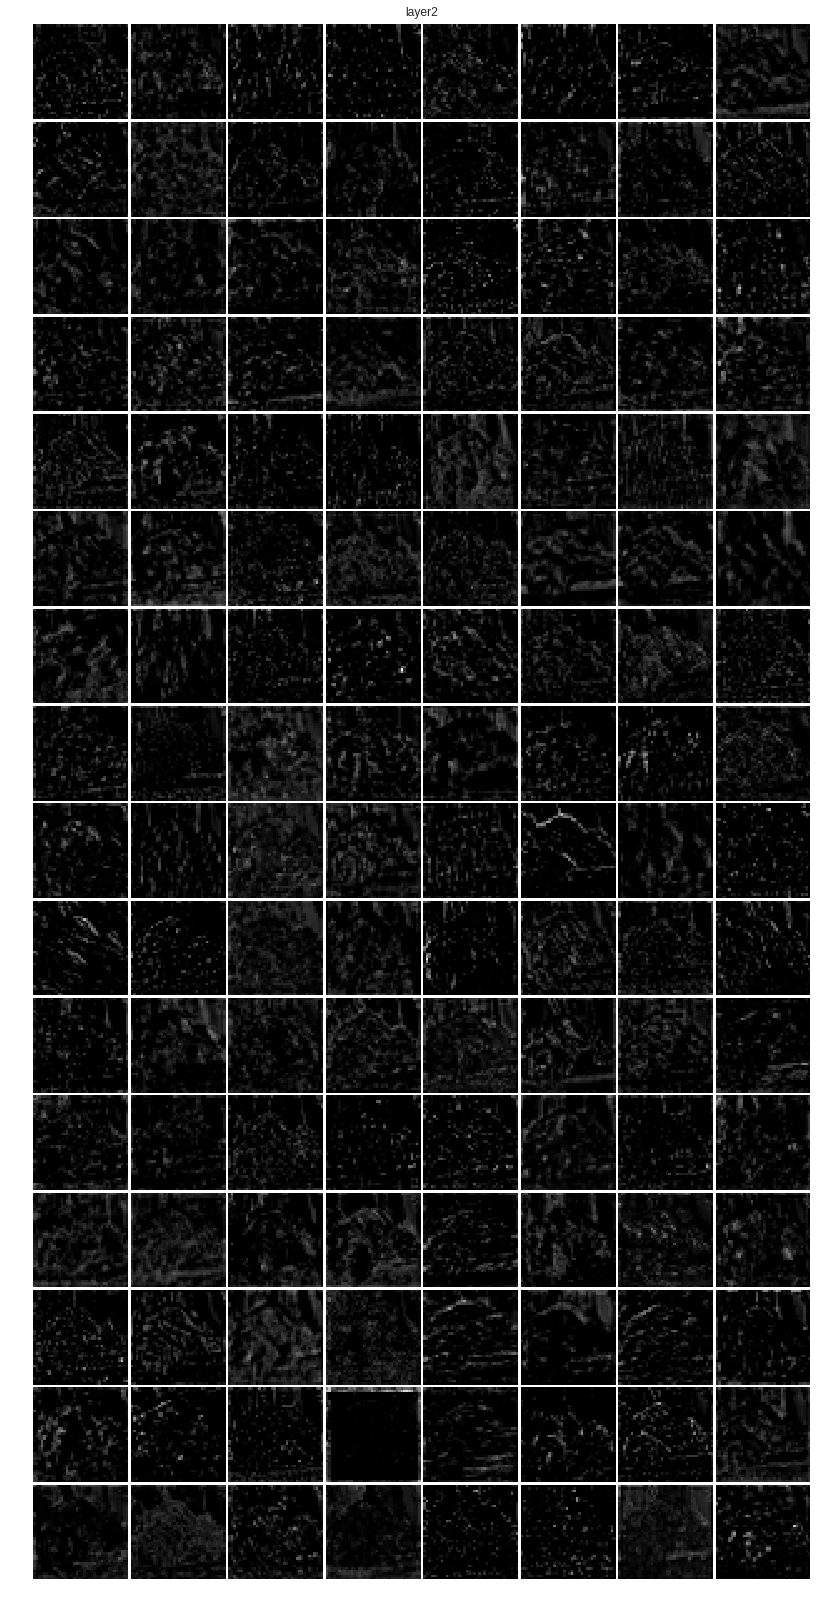

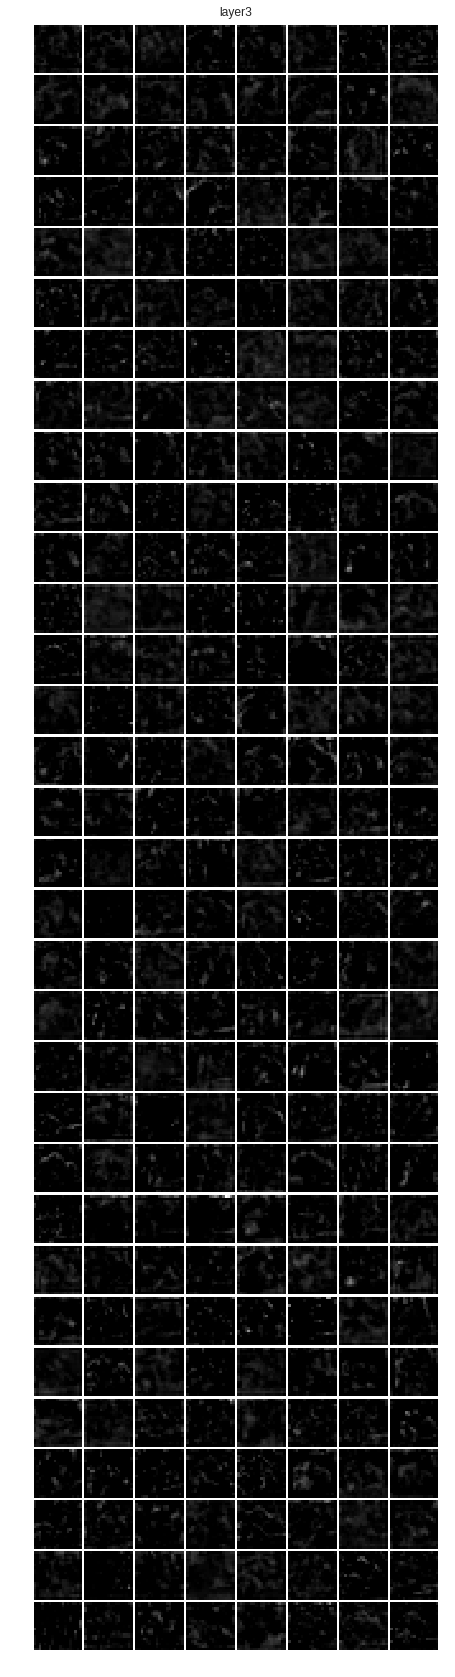

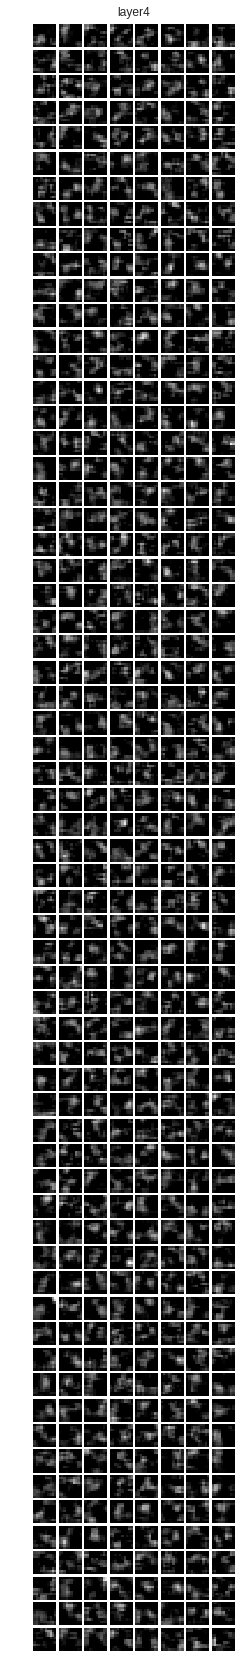

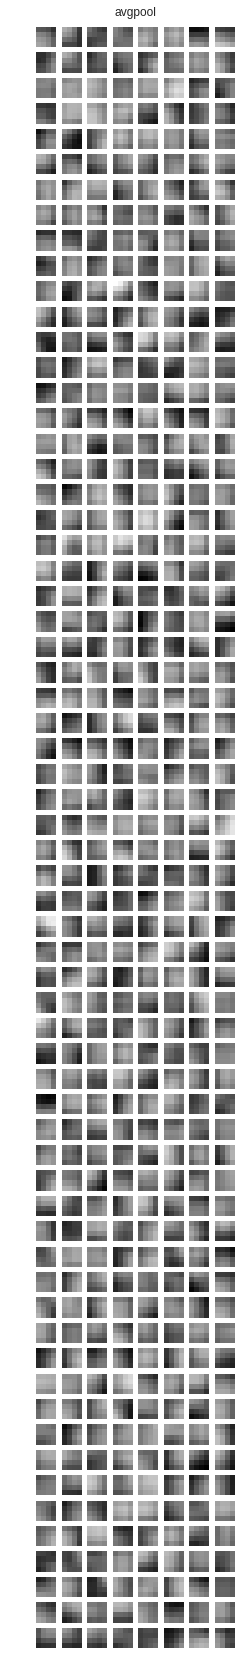

In [35]:
#plot_layers_weight(dsets['train'], img_width=img_width, img_height=img_height, conv_model = convnet, use_gpu=use_gpu)

# Generate Submission File

In [0]:
import datetime

def create_submission(results, info):


    predictions = torch.nn.functional.softmax(Variable(results['pred'])).cpu().data.numpy().tolist()
    predictions = np.around(predictions, decimals=3)
    predictions = np.clip(predictions, 0.001, 0.999) 

    print('Predictions size: {}'.format(predictions.shape))

    tst_img_lst = []

    for img in dsets['test'].X:
        tst_img_lst.append(img.split('/')[-1].split('.')[0])

    result_sample = pd.DataFrame(predictions, columns=labels_pivot.columns[1:])
    result_sample.loc[:, 'id'] = pd.Series(tst_img_lst, index=result_sample.index)


    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')


    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result_sample.to_csv(sub_file, index=False)
    print('File saved: {}'.format(sub_file))
    print('done!')
    
    return sub_file

In [107]:
sub_file = create_submission(results['test'], 'DogBreed')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Predictions size: (10357, 120)
Files saved: subm/submission_DogBreed_2018-05-23-00-19.csv
done!


In [108]:
!cd subm && ls

submission_DogBreed_2018-05-22-23-54.csv
submission_DogBreed_2018-05-23-00-19.csv


In [0]:
from google.colab import files


files.download(sub_file)

In [0]:
#!kill -9 -1